# Building GPT 

Building on part 5 and implementing attention block: 
* Single attention head 
* Multi attention head 
* Dropout and residual connections 

In [1]:
import torch
import torch.nn as nn 
from torch.nn import functional as F 

In [49]:
# hyperparams 
batch_size = 128         # num of independent sequences processed in parallel
block_size = 16        # context length 
max_iters = 15000        # num of training iterations 
eval_interval = 1000     # evaluate loss every x intervals
eval_iters = 200        # num of iterations to average loss over  
learning_rate = 1e-3   
n_embd = 64             # head_size * n_head 
n_head = 2              # num heads in multi-attention head
n_layer = 3             # num blocks
dropout = 0.2           # probability of each token getting dropped out at each dropout 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1337)

In [ ]:
# read text 
with open('data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# encode text
data = torch.tensor(encode(text), dtype=torch.long)

print('vocab size: ', vocab_size)

vocab size:  65


In [9]:
# split data into train and validation 
n = int(0.9 * len(data)) 
train_data = data[:n]
val_data = data[n:] 

# print training data
print('train: ', train_data.shape, 'val: ', val_data.shape, data.dtype)
print(train_data[:50]) # first 100 characters, encoded

train:  torch.Size([1003854]) val:  torch.Size([111540]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56])


In [28]:
# data loading
def get_batch(split): 
    # generate small batch of inputs x and targets y 
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y 

# print batch  
xb, yb = get_batch('train')
print ('inputs:')
print(xb.shape)
print(xb[:4, :]) # first 4 rows in batch
print('targets')
print(yb.shape)
print(yb[:4, :])

for b in range(batch_size): # batch dim 
    for t in range(block_size): # time dim
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} target: {target}")


inputs:
torch.Size([32, 16])
tensor([[57, 50, 43, 61,  5, 57, 58,  1, 32, 63, 40, 39, 50, 58, 11,  1],
        [59, 56, 57, 43,  6,  1, 53, 56,  1, 43, 50, 57, 43,  1, 58, 46],
        [43, 46, 43, 50, 42,  7,  7,  0,  0, 25, 13, 30, 15, 21, 33, 31],
        [ 1, 46, 43,  1, 61, 43, 56, 43,  1, 51, 63,  1, 40, 56, 53, 58]])
targets
torch.Size([32, 16])
tensor([[50, 43, 61,  5, 57, 58,  1, 32, 63, 40, 39, 50, 58, 11,  1, 58],
        [56, 57, 43,  6,  1, 53, 56,  1, 43, 50, 57, 43,  1, 58, 46, 63],
        [46, 43, 50, 42,  7,  7,  0,  0, 25, 13, 30, 15, 21, 33, 31, 10],
        [46, 43,  1, 61, 43, 56, 43,  1, 51, 63,  1, 40, 56, 53, 58, 46]])
when input is [57] target: 50
when input is [57, 50] target: 43
when input is [57, 50, 43] target: 61
when input is [57, 50, 43, 61] target: 5
when input is [57, 50, 43, 61, 5] target: 57
when input is [57, 50, 43, 61, 5, 57] target: 58
when input is [57, 50, 43, 61, 5, 57, 58] target: 1
when input is [57, 50, 43, 61, 5, 57, 58, 1] target: 32
whe

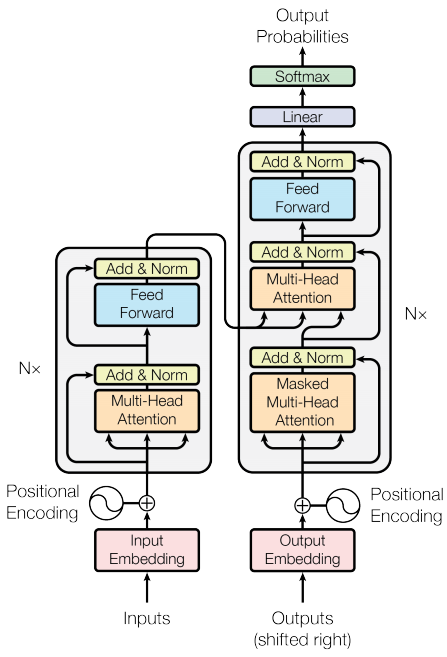

In [ ]:
from IPython.display import Image
Image(filename='images/attention.png')

## Understanding autoregressive models

Autoregressive models like GPT are designed to generate output one token at a time, using only past context. They use only a **decoder**, which is causal (masked self-attention so tokens can only see past tokens)
* Encoder - Looks at the full input sequence (bidirectional - use case: sentiment analysis)
* Decoder - Looks only at past tokens (causal, autoregressive: use case: language modelling)

### What is in a decoder?

Many blocks which consist of: 
1) Attention layer: 
    * Allows tokens to ‘look’ at one another and gain information from context 
    * Linear combination of input vectors (focus on rships btw tokens)
2) Feedforward: 
    * Processes each token independently 
    * Non-linear transformations to individual token

Now we will try to implement an attention layer!

## Building an Attention Head

Simplified version: Within 1 example, we want each token to **get information from the previous tokens** to make a prediction on the next one. One simple way is to multiply with the **average of past tokens**.

`wei` = affinities, they tell us how much each token from the past contributes to our average. They are masked with a lower triangle bc future tokens don’t contribute. 

In [16]:
# Exercise: Building an attention head by taking average of past tokens

# example
B,T,n_embd = 4,8,2 
x = torch.randn(B,T,n_embd)

# v1: taking average
wei = torch.tril(torch.ones(T,T))  
wei = wei/wei.sum(1, keepdim=True)
xbow1 = wei @ x # (B, T, T) @ (B, T, C) --> (B, T, C)

# v2: using softmax 
tril = torch.tril(torch.ones(T,T))
wei2 = torch.zeros((T, T)) # set initial affinities between tokens to zero  
wei2 = wei2.masked_fill(tril==0, float('-inf')) # set affinities with future elements to -inf so they wont contribute to avg later in softmax
wei2 = F.softmax(wei2, dim=-1) # exponentiate then normalise
xbow2 = wei2 @ x

wei2

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Now we see that wei (affinities telling us how much each token contributes) is all uniform. However we don’t actually want it to be uniform because some tokens will find others more interesting, and we want it to be data dependent. Eg. vowel interested in consonants in the past.

Self attention does it by having every node emit 3 vectors:
* `query` - what am i looking for
* `key` - what do i contain (acts like a label) 
* wei - dot product of each token’s query and all tokens' key to give a relevance score - how much does this key match what i'm looking for? Mask to only include past tokens
* `value` - the actual info retrieved once a you decide which tokens are relevant 
* out - dot product of each token’s wei with  query and all tokens' key to give a relevance score

`head_size` - dimensionality of attention mechanism (q,k,v vectors)- how much detail or nuance each attention head can capture in its comparisons

* Input: x (B, T, n_embd) 
* Output per head: out (B, T, hs) 
* n_embd = hs * num_heads

In [19]:
# version 4: self attention

# setting up a single attention head 
head_size = 16 
key = nn.Linear(n_embd, head_size, bias=False )
query = nn.Linear(n_embd, head_size, bias=False )
value = nn.Linear(n_embd, head_size, bias=False )

# linear projection of n_embd to head_size for each token 
k = key(x)      # (B, T, 16)
q = query(x)    # (B, T, 16)
v = value(x)    # (B, T, 16)

# compute affinities
wei = q @ k.transpose(-2, -1) # (B,T,16) @ (B,16,T) --> (B,T,T)
# for each token in the sequence, get dot pdts btw its query and each key
# the result wei[b, i, j] measures how much token i should pay attention to token j in that batch

# apply causual mask and softmax 
tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril==0, float('-inf')) 
wei = F.softmax(wei, dim=-1)

# each token's output is a weighted average of value vectors
out = wei @ v # (B,T,T) @ (B,16,hs) --> (B,T,hs)
print('input: ', x.shape, 'output: ', out.shape)
print('wei: ')
wei[0]

input:  torch.Size([4, 8, 2]) output:  torch.Size([4, 8, 16])
wei: 


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5914, 0.4086, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2361, 0.1317, 0.6322, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3146, 0.1743, 0.3342, 0.1769, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3187, 0.1436, 0.2979, 0.1380, 0.1019, 0.0000, 0.0000, 0.0000],
        [0.0270, 0.1159, 0.0089, 0.0760, 0.1082, 0.6639, 0.0000, 0.0000],
        [0.1262, 0.1612, 0.1542, 0.1754, 0.1982, 0.0725, 0.1124, 0.0000],
        [0.1520, 0.1034, 0.1773, 0.1093, 0.0973, 0.0967, 0.1436, 0.1205]],
       grad_fn=<SelectBackward0>)

Notes: 
* **Attention** is a communication mechanism. Each token's output is a weighted average of all past token’s value vectors (weighted by how much attention it pays to each token)

* There is no notion of space, hence need to positional encoding later

* **Self attention** means keys and values are produced from the same source as queries. In **Cross-attention**, queries are from x, but the keys and values come from some other, external source (e.g. encoder module)

* **Decoders** have triangular masking that causes tokens to only be able to see past tokens; used in autoregressive settings like language modelling. **Encoders** exclude this, allowing all tokens to communicate; used in sentiment analysis all tokens can talk to predict the overall sentiment.

### Building a single Head 

* Scaled attention will additionally divide wei by 1/sqrt(head_size), which makes wei unit variance, so softmax does not saturate too much. 
Without scaled attention: k.var() = 1, q.var() = 1 → wei.var() =  hs
After scaling: wei.var() = 1

* **Dropout** is a regularisation technique that randomly zeros some wei in each forward pass, prevents overfitting and forces the model to not rely too heavily on any single neuron.
Eg. `dropout = nn.Dropout(p=0.1)` - each wei has a probability p of being zeroed out. Remaining elements scale up by 1/(1-p).

In [21]:
class Head(nn.Module): 

    def __init__(self, head_size): 
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # w (n_embd, hs)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self,x): 
        B, T, C = x.shape   # x (B, T, n_embd) 

        k = self.key(x)     # k (B, T, hs) 
        q = self.query(x)   # q (B, T, hs)
        v = self.value(x)   # v (B, T, hs)
    
        # compute affinities
        wei = q @ k.transpose(-2, -1)  * k.shape[-1]**0.5   # (B,T,hs) @ (B,hs,T) -> (B,T,T)
        # wei[b, i, j] = how much token i should pay attention to token j in that batch
        # Scaled attention divides wei by 1/sqrt(head_size), wei is unit variance

        # apply causual mask + softmax
        wei = wei.masked_fill(self.tril[:T, :T] ==0, float('-inf'))
        wei = F.softmax(wei, dim=-1) 

        wei = self.dropout(wei)
        out = wei @ v       # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        # each token's output is a weighted average of value vectors
        return out 

### Building a Block 
A decoder consists of multiple blocks, each consisting of: 

1) **Multi head Attention layer**: 
* Allows tokens to ‘look’ at one another and gain information from context 
* Linear combination of input vectors (focus on rships btw tokens)
* How it happens:
    * Inputs into each Head(x) - (B, T, n_embd)
    * Outputs (B, T, hs) from each head are concatenated into (B, T, hs * num_heads), then passed through a linear layer to project back to original shape (B, T, n_embd)

2) **Feedforward**
* Processes each token independently via non-linear transformations 
* How it happens: 
    * Project the embedding into a higher-dimensional space, apply a non-linearity, and then project it back. This allows the model to learn more expressive transformations.
    * The intermediate dimension (4 * n_embd) gives the model room to mix and recombine features

In [22]:
class MultiHeadAttention(nn.Module):
    "multiple heads of self-attention in parallel"

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd) 
        # concatenate attn outputs across multi heads &
        # & project back to n_embd to enable subsequent layers to consume result
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x): 
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, hs * num_heads)
        out = self.dropout(self.proj(out))                  # (B, T, n_embd)
        return out 

"a simple linear layer followed by non linearity"
# computation in a per node level 

class FeedForward(nn.Module): 
    "a simple linear layer followed by non linearity"

    def __init__(self, n_embd): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(), 
            nn.Linear(4*n_embd, n_embd), 
            nn.Dropout(dropout)
        )
    
    def forward(self, x): 
        return self.net(x)

**In a block**: 
* x -> LayerNorm -> Multi head Attention layer -> Residual connection -> LayerNorm -> Feedforward layer  -> Residual connection 

* `LayerNorm`: Transformers use LayerNorm instead of BatchNorm 
    * For input x: (B, T, n_embd)
     LN works across n_embd – per-token normalization across features 
    * BN works across B –, per-batch normalisation. Doesn’t work as transformers have variable batch sizes and even batch size = 1. BN needs multiple samples to compute statistics
* `Residual connection`: When applying a transformation F(x) to input x, instead of `out = F(x)`, do `out = x + F(x)`. Helps with:
    * Gradient flow: In deep networks, gradients can vanish. Skip connection allows gradient of x to flow directly to out, stabilising training
    * Let model learn an adjustment instead of full transformation: Eg. if model must learn out = x 
        * Without residuals, model must learn F(x) ≈ x. learn the full identity map F(x) to rebuild x from scratch 
        * With residuals, out = x + F(x) → model must learn F(x)≈0. If the best thing the layer can do is “do nothing,” it only needs to output zeros, or it can learn small tweaks. This is way easier than learning to rebuild x 



In [23]:
class Block(nn.Module): 
    " Block: communication followed by computation"

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head 
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x): 
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x 

## Putting it all into GPT model 

In [25]:
class GPTModel(nn.Module): 

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        self.apply(self._init_weights) # initialise weights & biases in layers 
    
    # initialise linear & embedding layer: weights to small normal distrib; bias to 0
    def _init_weights(self, module): 
        if isinstance(module, nn.Linear): 
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:  
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding): 
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets = None): 
        B, T = idx.shape # idx (B, T): current context
        
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embd)
        x = tok_emb + pos_emb 
        x = self.blocks(x)  # transformer block (B, T, n_embd)
        x = self.ln_f(x)    # layernorm (B, T, n_embd)
        logits = self.lm_head(x) # lm_head (B, T, vocab_size)

        # get loss
        if targets is None: 
            loss = None 
        else: 
            B, T, C = logits.shape 
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss 
    
    def generate(self, idx, max_new_tokens): 
        # idx is (B, T) array of indices in current context 
        for _ in range(max_new_tokens): 
            # crop idx to last block_size tokens (embs only have up to block_size embd)
            idx_cond = idx[:, -block_size:]

            # get predictions for each time step in input 
            logits, loss = self(idx_cond)
            # logits[:, 0, :] - prediction for what comes aft token 1
            # logits[:, 1, :] - prediction for what comes aft token 1, 2 
            # logits[:, 2, :] - prediction for what comes aft token 1, 2, 3

            # get predictions for next token after all tokens in input
            logits = logits[:, -1, :] # (B,C)

            # apply softmax to get probabilities 
            probs = F.softmax(logits, dim=-1)

            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # append sampled index to the running sequence 
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Training**: 
* Set an AdamW optimiser that knows which parameters to update and at what learning rate. 
* Get a batch of data xb and yb (B, T) each 
* Evaluate loss 
* Using optimiser: 
    * Set all gradients of params to zero 
    * Use `loss.backwards()` to calculate gradients 
    * Use `.step()` to update params with gradients 
* For every eval_interval iterations, print average loss of training and validation sets across eval_iters using `estimate_loss()`

**Generation:**

`context = torch.zeros((1, 1), dtype=torch.long, device=device) `
* Creates a starting input tensor for the model.
* Shape (1, 1) → batch size of 1, sequence length of 1.
* The value is 0, which corresponds to the first token in your vocabulary.

`m.generate(context, max_new_tokens=500)`
* Calls the model's generate method to predict the next token 500 times 
* It maintains the last block_size tokens as context (due to the positional embedding limits)


`[0].tolist()`
* The output of generate is a tensor of shape (1, 501) (original + 500 new tokens).
* [0] extracts the first (and only) sequence from the batch.
* .tolist() converts the tensor to a Python list of integers to then be decoded


In [43]:
@torch.no_grad
def estimate_loss(): 
    # average the loss for both train and val over a few iterations 
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters): 
            X, Y = get_batch (split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [50]:
model = GPTModel()
m = model.to(device)
# print number of params 
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# optimise
optimiser = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    
    # every once in a while evaluate loss on train and val sets 
    if iter % eval_interval == 0 or iter == max_iters-1: 
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate loss 
    logits, loss = model(xb, yb)
    optimiser.zero_grad(set_to_none= True)
    loss.backward()
    optimiser.step()

# generate from the model 
context = torch.zeros((1, 1), dtype = torch.long, device = device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

print("batch_size:", batch_size)
print("block_size:", block_size)
print("max_iters:", max_iters)
print("eval_interval:", eval_interval)
print("eval_iters:", eval_iters)
print("learning_rate:", learning_rate)
print("n_embd:", n_embd)
print("n_head:", n_head)
print("n_layer:", n_layer)
print("dropout:", dropout)

0.158913 M parameters
step 0: train loss 4.1930, val loss 4.1931
step 1000: train loss 1.8946, val loss 1.9943
step 2000: train loss 1.7729, val loss 1.9085
step 3000: train loss 1.7296, val loss 1.8825
step 4000: train loss 1.6963, val loss 1.8602
step 5000: train loss 1.6858, val loss 1.8557
step 6000: train loss 1.6648, val loss 1.8381
step 7000: train loss 1.6581, val loss 1.8204
step 8000: train loss 1.6477, val loss 1.8151
step 9000: train loss 1.6384, val loss 1.8131
step 10000: train loss 1.6349, val loss 1.7986
step 11000: train loss 1.6273, val loss 1.8051
step 12000: train loss 1.6228, val loss 1.7817
step 13000: train loss 1.6201, val loss 1.7989
step 14000: train loss 1.6087, val loss 1.7798
step 14999: train loss 1.6129, val loss 1.7851

LEONTES:
And had, let
hareth see and your husest sho.

MERCUS:
More, sirvy what what's my man's pray meaning-atone upon she desterta's any loved day
to the king exio, and,, e'his I weven adow you'ld wifor'er lipine not tispass and nown,
I

**Untrained**

IdIR

T:NS
neeo :W:
A Noti reelxae'uusallv nhno aiee oet.:heeg
UThhkohs rwbiemtPTet  h,r'sphb t je

 ktnf,e w nnd,eldiiunrskesrw sepbku yoog s huadk neeo aede  in h
k lwtetelt ey tianty ttsst aes 
Ti.:B.CK MRN
WUywtoaoasrw f.

Pwrgtrkoi bgpet'odhusot tlsriten;kodsww,dbmt;nesde rhbe a!sbanto  ,srlfdo s  sdaiw dw'rrtelgien

IRo lnru
:C W

R tdlr, Werg ah; a,cir south sc tetbratv efeya  hrltrm y lbahnoacn,H nert, ted   tsmese  tenuionudrplotyoa s ot  ae hd  usrtm lh.Y:n wusar w cIYA
Beja,er.OU